In [1]:
import torch
import transformers
from ast import literal_eval
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import Dataset
import json
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import evaluate
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from peft import AutoPeftModelForCausalLM, LoraConfig

pd.set_option('display.max_columns', None)

In [2]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

In [20]:
train_dataset = pd.read_csv('../data/train.csv')

records = []
for _, row in train_dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', ''),
        'question_plus': problems.get('question_plus', '')
    }
    records.append(record)

train_df = pd.DataFrame(records)
train_df.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,


In [19]:
test_dataset = pd.read_csv('../data/test.csv')

records = []
for _, row in test_dataset.iterrows():
    problems = literal_eval(row['problems'])
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': problems['question'],
        'choices': problems['choices'],
        'answer': problems.get('answer', ''),
        'question_plus': problems.get('question_plus', '')
    }
    records.append(record)

test_df = pd.DataFrame(records)
test_df.head()

,id,paragraph,question,choices,answer,question_plus
0,generation-for-nlp-0,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다 . 독서의 즐거움에는 ...,윗글의 내용과 일치하지 않는 것은?,"[같은 책을 읽은 독자라도 서로 다른 의미를 구성할 수 있다 ., 다른 독자와의 소...",,
1,generation-for-nlp-1,사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다 . 독서의 즐거움에는 ...,윗글을 읽고 ㉠에 대해 보인 반응으로 적절하지 않은 것은?,[스스로 독서 계획을 세우고 자신에게 필요한 책을 찾아 개인적 으로 읽는 과정에서 ...,,
2,generation-for-nlp-2,(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집하고 항목별로...,(가 )와 (나 )에 대한 설명으로 가장 적절한 것은?,"[(가 )는 유서의 유형을 분류하였고 , (나 )는 유서의 분류 기준과 적절성...",,
3,generation-for-nlp-3,(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집하고 항목별로...,[A ]에 대한 이해로 적절하지 않은 것은?,[조선에서 편찬자가 미상인 유서가 많았던 것은 편찬자의 개인적 목적으로 유서를 활...,,
4,generation-for-nlp-4,(가 ) 중국에서 비롯된 유서( 類書)는 고금의 서적에서 자료를 수집하고 항목별로...,"㉮에 대한 이해를 바탕으로 ㉠ , ㉡에 대해 파악한 내용으로 적절하지 않은 것은?","[지식의 제공이라는 ㉮의 편찬 의도는, ㉠에서 지식을 심화하고 확장하여 소개한...",,


In [5]:
plus_train = train_df[train_df['question_plus'] != '']
print(f'question_plus가 있는 train 데이터 개수: {len(plus_train)}')

plus_test = test_df[test_df['question_plus'] != '']
print(f'question_plus가 있는 test 데이터 개수: {len(plus_test)}')

question_plus가 있는 train 데이터 개수: 0
question_plus가 있는 test 데이터 개수: 44


In [6]:
train_df['question'] = train_df.apply(lambda x: x['question'] + ' <보기>' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)
test_df['question'] = test_df.apply(lambda x: x['question'] + ' <보기>' + x['question_plus'] if x['question_plus'] else x['question'], axis=1)

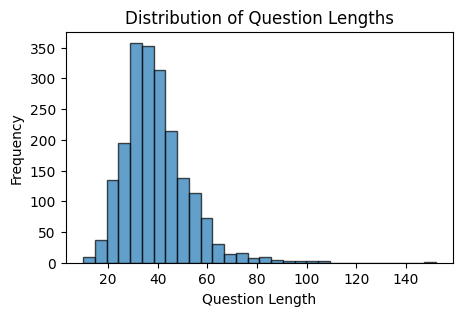

In [8]:
# Calculate the length of each question
train_df['question_length'] = train_df['question'].apply(len)

plt.figure(figsize=(5, 3))
plt.hist(train_df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

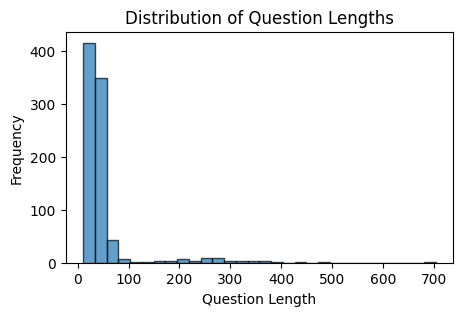

In [9]:
# Calculate the length of each question
test_df['question_length'] = test_df['question'].apply(len)

plt.figure(figsize=(5, 3))
plt.hist(test_df['question_length'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# model_name = "beomi/gemma-ko-2b"

model = AutoModelForCausalLM.from_pretrained(
    "CarrotAI/Llama-3.2-Rabbit-Ko-3B-Instruct",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "CarrotAI/Llama-3.2-Rabbit-Ko-3B-Instruct",
    trust_remote_code=True,
)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# chat_template 설정
if not hasattr(tokenizer, "chat_template"):
    tokenizer.chat_template = """
    {% if messages[0]['role'] == 'system' %}
        {% set system_message = messages[0]['content'] %}
    {% endif %}
    {% if system_message is defined %}
        {{ system_message }}
    {% endif %}
    {% for message in messages %}
        {% set content = message['content'] %}
        {% if message['role'] == 'user' %}
            {{ '<start_of_turn>user\n' + content + '<end_of_turn>\n<start_of_turn>model\n' }}
        {% elif message['role'] == 'assistant' %}
            {{ content + '<end_of_turn>\n' }}
        {% endif %}
    {% endfor %}
    """

In [12]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.05,
    target_modules=['q_proj', 'k_proj'],
    bias='none',
    # task_type="CAUSAL_LM"
)

In [13]:
train = Dataset.from_pandas(train_df)
test = Dataset.from_pandas(test_df)

In [14]:
PROMPT = """지문:
{paragraph}

질문:
{question}

선택지:
{choices}

1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.
정답:"""

In [15]:
system_message = "지문을 읽고 질문의 답을 구하세요."

processed_train = []
for i in range(len(train)):
    choices_string = "\n".join([f"{idx + 1} - {choice}" for idx, choice in enumerate(train[i]['choices'])])

    user_message = PROMPT.format(
        paragraph = train[i]['paragraph'],
        question = train[i]['question'],
        choices = choices_string,
    )

    processed_train.append(
        {
            "id": train[i]['id'],
            "messages": [
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": f"{train[i]['answer']}"}
            ],
            "label": train[i]['answer'],
        }
    )

processed_train = Dataset.from_pandas(pd.DataFrame(processed_train))
processed_train[0]

{'id': 'generation-for-nlp-425',
 'messages': [{'content': '지문을 읽고 질문의 답을 구하세요.', 'role': 'system'},
  {'content': '지문:\n상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服) 절차에 대하여 논한 것이 신과는 큰 차이가 있었습니다 . 장자를 위하여 3년을 입는 까닭은 위로 ‘정체(正體)’가 되기 때문이고 또 전 중(傳重: 조상의 제사나 가문의 법통을 전함)하기 때문입니다 . …(중략) … 무엇보다 중요한 것은 할아버지와 아버지의 뒤를 이은 ‘정체’이지, 꼭 첫째이기 때문에 참 최 3년 복을 입는 것은 아닙니다 .”라고 하였다 .－현종실록 －ㄱ.기 사환국으로 정권을 장악하였다 .ㄴ.인 조반정을 주도 하여 집권세력이 되었다 .ㄷ.정조 시기에 탕평 정치의 한 축을 이루었다 .ㄹ.이 이와 성혼의 문인을 중심으로 형성되었다.\n\n질문:\n상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?\n\n선택지:\n1 - ㄱ, ㄴ\n2 - ㄱ, ㄷ\n3 - ㄴ, ㄹ\n4 - ㄷ, ㄹ\n\n1, 2, 3, 4, 5 중에 하나를 정답으로 고르세요.\n정답:',
   'role': 'user'},
  {'content': '2', 'role': 'assistant'}],
 'label': 2}

In [16]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example["messages"])):
        output_texts.append(
            tokenizer.apply_chat_template(
                example["messages"][i],
                tokenize=False,
            )
        )
    return output_texts

def tokenize(element):
    outputs = tokenizer(
        formatting_prompts_func(element),
        truncation=False,
        padding=False,
        return_overflowing_tokens=False,
        return_length=False,
    )
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

# 데이터 토큰화
tokenized_dataset = processed_train.map(
    tokenize,
    remove_columns=list(processed_train.features),
    batched=True,
    num_proc=4,
    load_from_cache_file=True,
    desc="Tokenizing",
)


Tokenizing (num_proc=4):   0%|          | 0/2031 [00:00<?, ? examples/s]

NameError: name 'tokenizer' is not defined

In [ ]:
# 데이터 분리
# vram memory 제약으로 인해 인풋 데이터의 길이가 1024 초과인 데이터는 제외하였습니다. *힌트: 1024보다 길이가 더 긴 데이터를 포함하면 더 높은 점수를 달성할 수 있을 것 같습니다!
tokenized_dataset = tokenized_dataset.filter(lambda x: len(x["input_ids"]) <= 1024)  
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test']
# 데이터 확인
print(tokenizer.decode(train_dataset[0]["input_ids"], skip_special_tokens=True))